In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*")

In [ ]:
dataset = pd.read_csv('data/data.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

X_train, y_train = train_df.drop('Value', axis=1), train_df['Value']
X_test, y_test = test_df.drop('Value', axis=1), test_df['Value']

In [4]:
def recursive_forecast(model, X_last, n_steps, rolling_window=3):
    predictions = []
    
    for i in range(n_steps):
        rolling_mean = np.mean(X_last[-rolling_window:])
        rolling_std = np.std(X_last[-rolling_window:])
        
        is_weekend = 1 if (i % 7) >= 5 else 0
        hour = (X_last[-1] + 1) % 24
        
        X_last = np.roll(X_last, shift=-1)
        X_last[-1] = rolling_mean
        X_last = np.roll(X_last, shift=-1)
        X_last[-2] = rolling_std
        X_last = np.roll(X_last, shift=-1)
        X_last[-3] = is_weekend
        X_last = np.roll(X_last, shift=-1)
        X_last[-4] = hour
        
        next_pred = model.predict(X_last.reshape(1, -1))[0]
        predictions.append(next_pred)
        
    return np.array(predictions)

# def recursive_forecast(model, X_last, n_steps, rolling_window=3):
#     predictions = []
#     predictions.append(model.predict(X_last.reshape(1, -1))[0])

#     for i in range(1, n_steps):
#         # rolling_mean = np.mean(X_last[2:5])
#         # rolling_std = np.std(X_last[2:5])
#         # is_weekend = 1 if (X_last[1] + i % 7) >= 5 else 0
        
#         X_last[0] = (X_last[0] + 1) % 24
#         X_last[4] = X_last[3]
#         X_last[3] = X_last[2]
#         X_last[2] = predictions[-1]
#         X_last[5] = np.mean(X_last[2:5])
#         X_last[6] = np.std(X_last[2:5]) 

#         # X_last = np.roll(X_last, shift=-1)
#         # X_last[-1] = rolling_mean
#         # X_last = np.roll(X_last, shift=-1)
#         # X_last[-2] = rolling_std
#         # X_last = np.roll(X_last, shift=-1)
#         # X_last[-3] = is_weekend
#         # X_last = np.roll(X_last, shift=-1)
#         # X_last[-4] = hour
        
#         next_pred = model.predict(X_last.reshape(1, -1))[0]
#         predictions.append(next_pred)
        
#     return np.array(predictions)

Random Forest - MAE: 1.24, RMSE: 2.07
MAE for 10-step forecast: 1.87
RMSE for 10-step forecast: 2.56


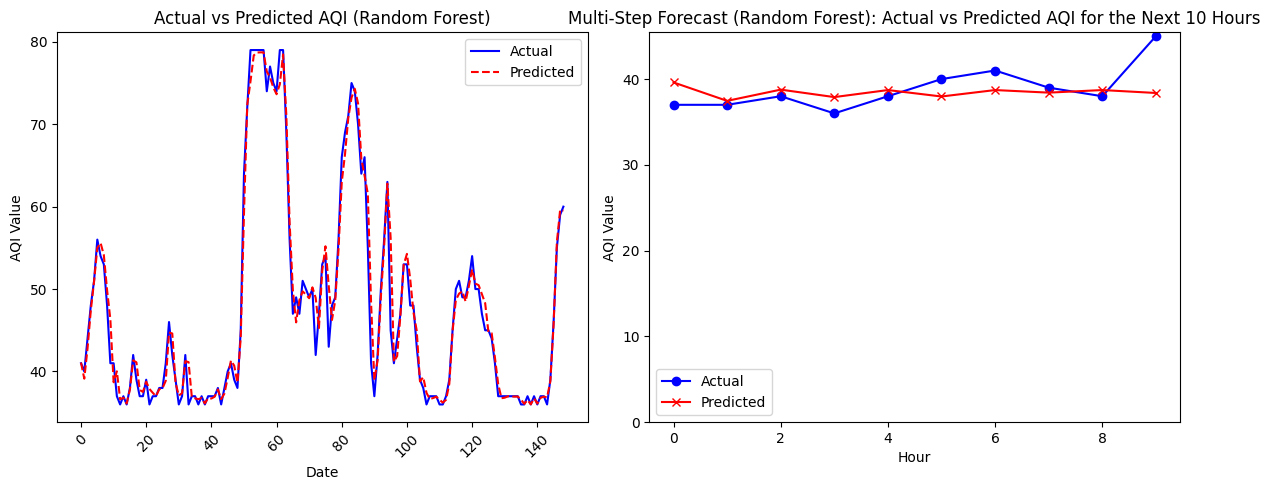

Gradient Boosting - MAE: 1.31, RMSE: 1.91
MAE for 10-step forecast: 4.15
RMSE for 10-step forecast: 5.25


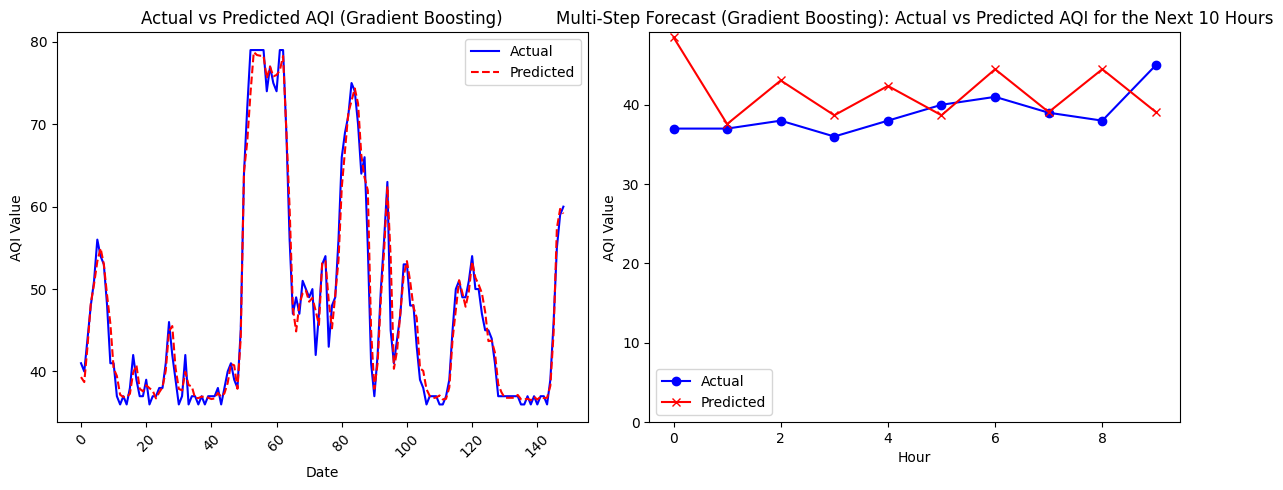

XGBoost - MAE: 1.00, RMSE: 1.74
MAE for 10-step forecast: 3.31
RMSE for 10-step forecast: 3.81


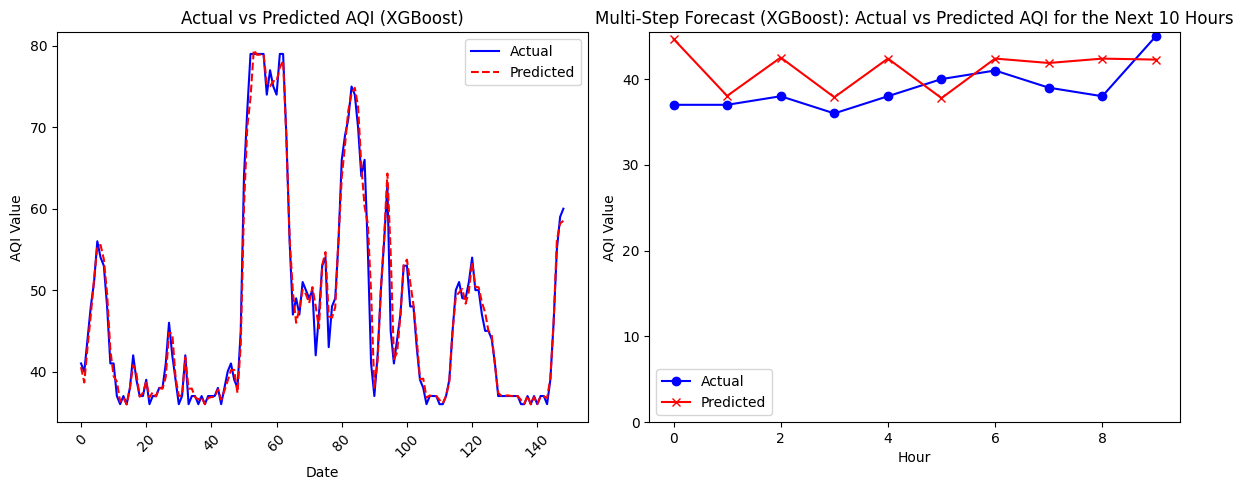

SVR - MAE: 3.14, RMSE: 4.44
MAE for 10-step forecast: 4.83
RMSE for 10-step forecast: 5.86


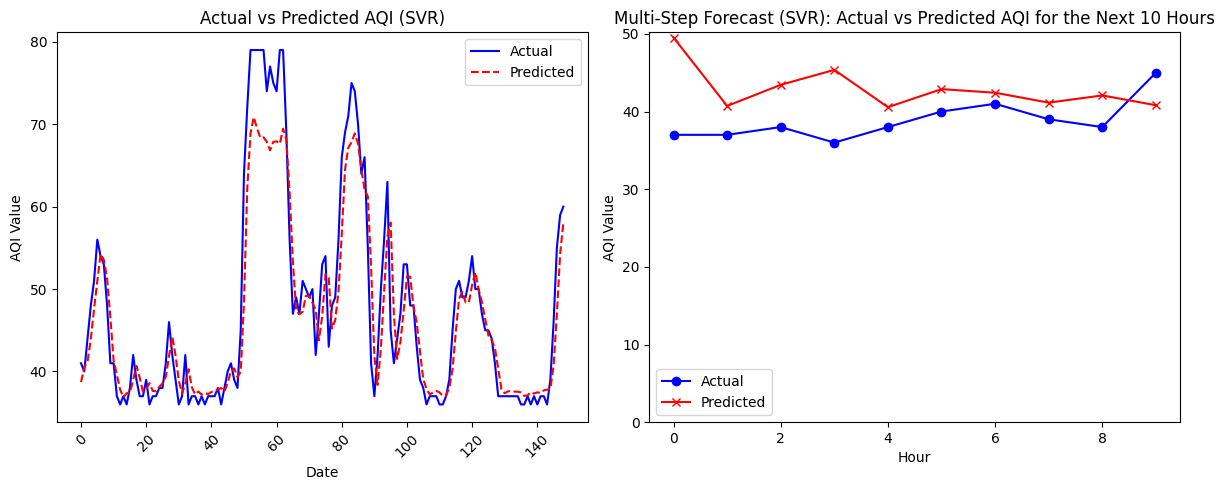

In [ ]:
import pickle

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf')
}

results = {}

for model_name, model in models.items():
    with open(f'artifacts/{model_name}.pkl', "rb") as file:
        model = pickle.load(file)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[model_name] = {'mae': mae, 'rmse': rmse, 'y_pred': y_pred}

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(y_test.index, y_test, label='Actual', color='blue')
    ax[0].plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
    ax[0].set_title(f'Actual vs Predicted AQI ({model_name})')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('AQI Value')
    ax[0].legend()
    ax[0].tick_params(axis='x', rotation=45)

    n_steps = 10
    starting_point = 40
    X_last = X_test.iloc[starting_point].values
    predicted_values = recursive_forecast(model, X_last, n_steps=n_steps)

    actual_values = y_test.iloc[starting_point:n_steps+starting_point].values  

    ax[1].plot(range(n_steps), actual_values, label='Actual', marker='o', color='blue')
    ax[1].plot(range(n_steps), predicted_values, label='Predicted', marker='x', color='red')
    ax[1].set_title(f'Multi-Step Forecast ({model_name}): Actual vs Predicted AQI for the Next {n_steps} Hours')
    ax[1].set_xlabel('Hour')
    ax[1].set_ylabel('AQI Value')
    ax[1].set_ylim(bottom=0)
    ax[1].legend()

    mae_multi_step = mean_absolute_error(actual_values, predicted_values)
    rmse_multi_step = np.sqrt(mean_squared_error(actual_values, predicted_values))

    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    print(f"MAE for {n_steps}-step forecast: {mae_multi_step:.2f}")
    print(f"RMSE for {n_steps}-step forecast: {rmse_multi_step:.2f}")

    plt.tight_layout()
    plt.show()